In [241]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np

In [7]:
words = open('../makemore/names.txt').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [39]:
def build_dataset(words, n_context=3):
    block_size = n_context  # context, how many words you use to predict the next one
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)  # input
            Y.append(ix)  # correct prediction
            # print(''.join(itos[i] for i in context), '------>', itos[ix])
            # crop and append / slide context over by one
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

## E01: Tuen the hyperparameters to beat validation loss of 2.2

Techinically the example he gives in the video is a little bit less than 2.2 already. But after playing around with things for a bit I thought you could probably reduce the loss by upping the context. If 3 tokens are embedded in 10 dimensions well I thought 15 would be plenty for 4 (rough heuristic that each could use ~3 dimensions which now that I am thinking of it is probably grossly wrong and I should be thinking more about the number of combinations of 4 words vs 3?). Likewise if 200 neurons was good for 3 tokens then 300 would be good for 4 (just estimating roughly linear scaling). I looked up some more sophisticated ways of doing the weight decay and chose exponential instead of a step function. The most import thing was probably the regularization actually. Even with keeping the other hyperparameters at the same value that would improve the validation loss I think. Upping the batch size helped I think a bit with convergence as well. Trying a few values of the regularization strength I got a loss of about 2.0.

In [516]:
d_embed = 15
n_context = 4
n_neurons = 300
reg_strength = 0.0045

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], n_context=n_context)
Xdev, Ydev = build_dataset(words[n1:n2], n_context=n_context)
Xte, Yte = build_dataset(words[n2:], n_context=n_context)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, d_embed), generator=g)
W1 = torch.randn((n_context*d_embed, n_neurons), generator=g)
b1 = torch.randn(n_neurons, generator=g)
W2 = torch.randn((n_neurons, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # num total params

for p in parameters:
    p.requires_grad = True

torch.Size([182660, 4]) torch.Size([182660])
torch.Size([22764, 4]) torch.Size([22764])
torch.Size([22722, 4]) torch.Size([22722])
26832


In [498]:
lrs = torch.logspace(-3, 0, 1000)

In [499]:
lri = []
lossi = []
stepi = []

In [500]:
n_loops = 100_000
for i in range(n_loops):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (512,))  # 32 random rows

    # forward pass
    # (nexamples, chars in context, dim of embedding space)
    emb = C[Xtr[ix]]
    #print(emb.shape)
    h = torch.tanh(emb.view(-1, n_context*d_embed) @ W1 + b1)  # (nexamples, context*dim)
    #print(h.shape)
    logits = h @ W2 + b2  # (32, 27)
    #print(logits.shape, Ytr[ix].shape)
    loss = F.cross_entropy(logits, Ytr[ix])
    reg = 0
    for p in parameters:
        reg += reg_strength * p.norm()
    loss += reg
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    #lr = lrs[i]
    lr = 1*np.exp(-2*i/n_loops)
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lr)
    stepi.append(i)
    lossi.append(loss.item())
print(loss.item())

2.123566150665283


In [501]:
# exponential moving average smoothing (from chatgpt)
def smooth_curve(points, smoothing=0.9):
    smoothed_points = []
    last = points[0]
    for point in points:
        smoothed_val = last * smoothing + (1 - smoothing) * point
        smoothed_points.append(smoothed_val)
        last = smoothed_val
    return smoothed_points

smoothed_loss = smooth_curve(lossi, smoothing=0.99)

2.123566150665283


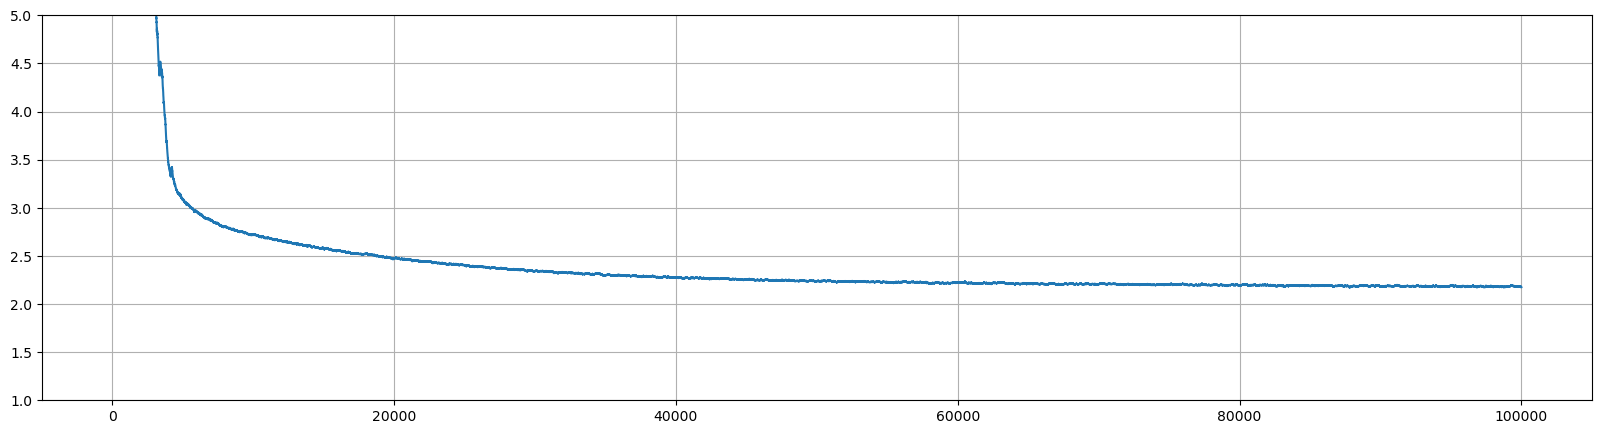

In [502]:
plt.figure(figsize=(20, 5))
plt.plot(stepi, smoothed_loss)
plt.grid()
plt.ylim(1,5)
print(lossi[-1])

In [503]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, n_context*d_embed) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print('TRAIN LOSS', loss.item())

TRAIN LOSS 1.8911263942718506


In [504]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, n_context*d_embed) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print('DEV LOSS', loss.item())

DEV LOSS 2.02321720123291


In [522]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, n_context*d_embed) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print('TEST LOSS', loss.item())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (22804x45 and 60x300)

## E02:  I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

(1) loss = 3.2958, taken from setting the logits to be all the same as each other.
(2) Yes. Just set all the parameters to the same value.

In [544]:
n_context = 3
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], n_context=n_context)
Xdev, Ydev = build_dataset(words[n1:n2], n_context=n_context)
Xte, Yte = build_dataset(words[n2:], n_context=n_context)

ones = torch.ones((Yte.shape[0], 27))
F.cross_entropy(ones, Yte)

torch.Size([182620, 3]) torch.Size([182620])
torch.Size([22766, 3]) torch.Size([22766])
torch.Size([22760, 3]) torch.Size([22760])


tensor(3.2958)

In [545]:
d_embed = 10
n_context = 3
n_neurons = 200
reg_strength = 0

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], n_context=n_context)
Xdev, Ydev = build_dataset(words[n1:n2], n_context=n_context)
Xte, Yte = build_dataset(words[n2:], n_context=n_context)

g = torch.Generator().manual_seed(2147483647)
C = torch.ones((27, d_embed))
W1 = torch.ones((n_context*d_embed, n_neurons))
b1 = torch.ones(n_neurons)
W2 = torch.ones((n_neurons, 27))
b2 = torch.ones(27)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # num total params

for p in parameters:
    p.requires_grad = True


emb = C[Xte]
h = torch.tanh(emb.view(-1, n_context*d_embed) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print('TEST LOSS', loss.item())

torch.Size([182530, 3]) torch.Size([182530])
torch.Size([22911, 3]) torch.Size([22911])
torch.Size([22705, 3]) torch.Size([22705])
11897
TEST LOSS 3.295837163925171


## E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?
